## CNN autoencoder
## convLSTM autoencoder?

## make time steps overlapping
## $\textit{done}$ try id as binary instead of dec: much better!
## double check that the reshaped matrices have data at correct places

## 3d (40 time steps) cnn better than cnn_lstm, try lstm after?
## 3d lstm performs better on 40 ts (40 is slightly different!) than 20 , test with binary cross entropy instead of mse, test 60 timesteps
more time steps pull normal and attack apart more, but I think this is because there are many consequtive attack packets in the data and in many cases longer time windows will simply contain more attack packets. 
## tune 3d cnn
## compare with straight forward lstm. keep getting NaN, exploding/vanishing gradients?
## just add ids as another feature normal lstm?
## convLSTM 
## randomly pick boxes from entire dataset
## batch normalization

## Prepare data

In [1]:
from matplotlib import pyplot
import keras
import tensorflow as tf
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import TimeDistributed 
from keras.layers import RepeatVector
from keras.layers import GRU
from keras.layers import Conv3D
from keras.layers import UpSampling3D
from keras.layers import MaxPool3D
from keras.layers import Conv2D
from keras.layers import UpSampling2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import GlobalAveragePooling2D
from keras.layers import Conv2DTranspose
from keras.layers import Conv3DTranspose

from keras.utils import plot_model
from keras.callbacks import EarlyStopping
import numpy as np
from numpy import array

In [2]:
from data_processing import process
filename = 'gear_dataset.csv'
#rows = 1000  # no attack data in the first 1000 rows
rown = 'slice'
data_with_attack, AttackIDs, labeled_data = process(filename,rows,no_attack_packets=False) 
print(f'including attack data: {data_with_attack.shape}')

data , IDs, _ = process(filename,rows,no_attack_packets=True)
print(f'normal data: {data.shape}')

#n_rows = data.shape[0] 
#n_features = data.shape[1]


NameError: name 'rows' is not defined

In [3]:
n_timesteps = 40

labeled_data = labeled_data.reset_index(drop=True)

from prepare_data_cube import make_cubes

#type = 'timeDist_cnn'
#type = 'cnn_lstm'
type = 'cnn'
x_test,x_train,xA,lastA = make_cubes(IDs,AttackIDs,data,data_with_attack,n_timesteps,type,labeled_data)

attack = labeled_data[labeled_data['Attack'] == 'T'].copy()
attack_ind = attack.index
attack_ind = attack_ind[attack_ind<=lastA]
attack_samples = np.floor(attack_ind/n_timesteps)
attack_samples = np.unique( attack_samples) # all samples that contain attack packets
attack_samples = attack_samples.astype(int)

last time step = 960, last attack time step = 960
x_test shape = (8, 40, 64, 17, 1), x_train shape = (16, 40, 64, 17, 1), with attack = (24, 40, 64, 17, 1)


In [ ]:
x_test[0,0,:,0,0]

In [12]:
lastA/n_timesteps

1239.0

## Build network

best value so far on lstm tuning: 
uniformMin = -0.89
uniformMax = 0.07
lstmUnits = 491
denseUnits = 2060
dropout = 0.3
learning_rate = 0.001
tuner/epochs = 2
tuner/initial_e... = 0
tuner/bracket = 4
tuner/round = 0


In [ ]:
# cnn
# channels?? 2d or 3d? think 3d because there are correlations between the two cannels
# relu much better than sigmoid
n_features = 64
depth = 2

input = Input(shape=(n_timesteps,n_features,depth, 1))

x = Conv3D(filters = 60, kernel_size = (2, 2, 1), activation='relu', padding='same')(input) 
x = Conv3D(filters = 60, kernel_size = (2, 2, 1), activation='relu', padding='same')(x)
#x = MaxPool3D((2,2,2),padding='valid')(x)

x = Conv3D(filters = 60, kernel_size = (2, 2, 1), activation='relu', padding='same')(x)
#x = UpSampling3D(size=(2, 2, 2))(x)

x = Conv3D(filters = 1, kernel_size = (2, 2, 1), activation='relu', padding='same')(x)

CNN = Model(inputs=input, outputs=x,name="CNN")
CNN.compile(optimizer='adam', loss='mse')
CNN.summary()


In [5]:

import time

#model = CNN
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)

s = time.time()

history = model.fit(x_train,x_train, validation_data=(x_test, x_test), epochs=300, verbose=0, shuffle=False, callbacks = [es])

e = time.time()

# plot history
pyplot.plot(history.history['loss'], label = 'train')
pyplot.plot(history.history['val_loss'], label = 'validation')

pyplot.legend()
pyplot.show()
print(f'training time = {e-s} seconds')



KeyboardInterrupt: 

input = Input(shape=(n_timesteps,n_features,n_channels, 1))

    *l1 = Conv3D(filters = 60, kernel_size = (2, 2, 2), activation='relu', padding='same')(input) * these are changed, kernel size and filters
    *l2 = Conv3D(filters = 60, kernel_size = (2, 2, 2), activation='relu', padding='same')(l1)
#l3 = MaxPool3D((2,2,2),padding='valid')(l2)
    *l4 = Conv3D(filters = 60, kernel_size = (2, 2, 2), activation='relu', padding='same')(l2)
    l5 = Conv3D(filters = 1, kernel_size = (2, 2, 2), activation='relu', padding='same')(l4) only change kernel size here
all using nrows = 1000, patience = 10, epochs = 300 

kernel in third dim must be smaller than input to be able to establish correlations in this dim.

loss: 120.9649 - val_loss: 235.5185 for kernel = 3,3,1, 16 filters    
loss: 76.3744 - val_loss: 161.5475 for kernel = 3,3,3, 16 filters  
loss: 6.2998 - val_loss: 7.3455 for kernel = 2, 2, 2, 60 filters  
loss: 24 - val_loss: 21.1457 for kernel = 2, 2, 2, 80 filters  
loss: 3.4384 - val_loss: 4.4540 for kernel = 2, 2, 1, 60 filters
loss: 8.4616 - val_loss: 604.7426 for kernel = 10, 2, 1, 60 filters (training time = 2193.382426261902 seconds) 

using nrows = 10000:
early stopping: Epoch 218/300: loss: 0.7777 - val_loss: 0.7862 (best around epoch 208:loss: 0.4987 - val_loss: 0.4804) for kernel = 2, 2, 1, 60 filters 40 timesteps!

In [13]:
attack_samples.shape

(692,)

(697, 40, 64, 17, 1)
normal: 0.29962672209866237
(1239, 40, 64, 17, 1)
normal and attack: 0.3223033819845312
(756, 40, 64, 17, 1)
only attack: 0.3368178783547764
(697,)
(756,)


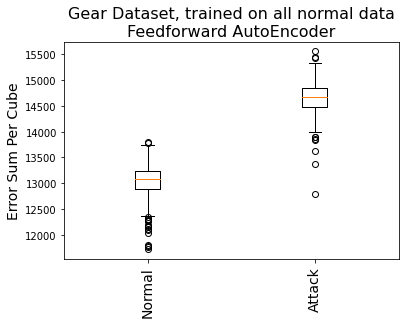

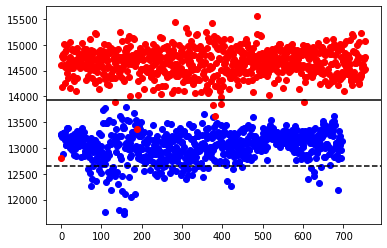

In [4]:
model =  keras.models.load_model('CNN_LSTM_monday')
# test with attack included

CNN = model
from matplotlib import pyplot as plt  

if type == 'timeDist_cnn' or type == 'cnn':
    attack_cubes = xA[attack_samples,:,:,:,:]

if type == 'cnn_lstm':
    attack_cubes = xA[attack_samples,:,:,:]

x_test = x_train
yHat_normal = CNN.predict(x_test) # only normal packets
normal_errors = x_test-yHat_normal
print(yHat_normal.shape)
normal_errors = normal_errors.flatten()
normal_errors = np.abs(normal_errors)
normal_errors = np.mean(normal_errors)
print(f'normal: {normal_errors}')


# yHat_attack = CNN.predict(xA) # normal and attack packets
# attack_errors = xA-yHat_attack
# print(yHat_attack.shape)
# attack_errors = attack_errors.flatten()
# attack_errors = np.abs(attack_errors)
# attack_errors = np.mean(attack_errors)
# print(f'normal and attack: {attack_errors}')

yHat_true_attack = CNN.predict(attack_cubes) # only attack packets
true_attack_errors = attack_cubes-yHat_true_attack
print(yHat_true_attack.shape)
true_attack_errors = true_attack_errors.flatten()
true_attack_errors = np.abs(true_attack_errors)
true_attack_errors = np.mean(true_attack_errors)
print(f'only attack: {true_attack_errors}')


# get average for each sample cube 
normal_errors = x_test-yHat_normal

if type == 'timeDist_cnn' or type == 'cnn':
    normal_errors = normal_errors.reshape(normal_errors.shape[0],normal_errors.shape[1]*normal_errors.shape[2]*normal_errors.shape[3]*normal_errors.shape[4])

if type == 'cnn_lstm':
    normal_errors = normal_errors.reshape(normal_errors.shape[0],normal_errors.shape[1]*normal_errors.shape[2]*normal_errors.shape[3])

    
normal_errors = np.abs(normal_errors)
normal_errors = np.sum(normal_errors,axis=1)
#normal_errors = normal_errors/normal_errors.shape[0]
print(normal_errors.shape)

# attack_errors = xA-yHat_attack
# if type == 'timeDist_cnn' or type == 'cnn':
#     attack_errors = attack_errors.reshape(attack_errors.shape[0],attack_errors.shape[1]*attack_errors.shape[2]*attack_errors.shape[3]*attack_errors.shape[4])

# if type == 'cnn_lstm':
#     attack_errors = attack_errors.reshape(attack_errors.shape[0],attack_errors.shape[1]*attack_errors.shape[2]*attack_errors.shape[3])

# attack_errors = np.abs(attack_errors)
# attack_errors = np.sum(attack_errors,axis=1)
# #attack_errors = attack_errors/attack_errors.shape[0]
# print(attack_errors.shape)

true_attack_errors = attack_cubes-yHat_true_attack
if type == 'timeDist_cnn' or type =='cnn':
    true_attack_errors = true_attack_errors.reshape(true_attack_errors.shape[0],true_attack_errors.shape[1]*true_attack_errors.shape[2]*true_attack_errors.shape[3] *true_attack_errors.shape[4])

if type == 'cnn_lstm':
    true_attack_errors = true_attack_errors.reshape(true_attack_errors.shape[0],true_attack_errors.shape[1]*true_attack_errors.shape[2]*true_attack_errors.shape[3])

true_attack_errors = np.abs(true_attack_errors)
true_attack_errors = np.sum(true_attack_errors,axis=1)
#attack_errors = attack_errors/attack_errors.shape[0]
print(true_attack_errors.shape)

plt.figure()
plt.boxplot([normal_errors,true_attack_errors]) 
plt.xticks([1,2], ['Normal','Attack'], rotation='vertical', fontsize=14)
plt.ylabel('Error Sum Per Cube', fontsize=14)
plt.title('Gear Dataset, trained on all normal data\nFeedforward AutoEncoder', fontsize=16)

maxNormal = np.max(normal_errors) + 0.01*np.max(normal_errors)
minAttack = np.min(true_attack_errors) - 0.01*np.max(normal_errors)

plt.figure()
#plt.scatter(np.arange(len(attack_errors)),attack_errors,c='y')
plt.scatter(np.arange(len(normal_errors)), normal_errors,c='b',s=10 )
plt.scatter(np.arange(len(true_attack_errors)), true_attack_errors,c='r')
plt.axhline(y=maxNormal, color='k', linestyle='-')
plt.axhline(y=minAttack, color='k', linestyle='--')



In [ ]:
print(np.min(true_attack_errors))
print(np.max(normal_errors))


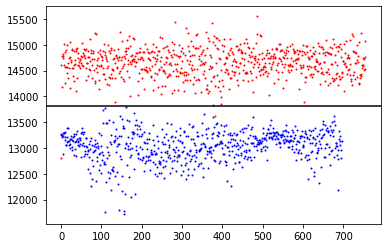

In [13]:
maxNormal = np.max(normal_errors) + 0.001*np.max(normal_errors)


plt.figure()
#plt.scatter(np.arange(len(attack_errors)),attack_errors,c='y')
plt.scatter(np.arange(len(normal_errors)), normal_errors,c='b',s=1 )
plt.scatter(np.arange(len(true_attack_errors)), true_attack_errors,c='r',s=1)
plt.axhline(y=maxNormal, color='k', linestyle='-')
#plt.axhline(y=minAttack, color='k', linestyle='--')

In [1]:
maxNormal = np.max(normal_errors) + 0.001*np.max(normal_errors)

false_normal = true_attack_errors[true_attack_errors<maxNormal]
n_false_normal = len(false_normal)
print(n_false_normal)
print(1-n_false_normal/len(true_attack_errors))
print(len(true_attack_errors))

#3 wrong, 0.996 acc 
#Regarding the CNN, the accuracy on 50 000 time steps where there are 9665 attack packets is 0.996 if I put the threshold 

NameError: name 'np' is not defined

In [ ]:
#cnn

input = Input(shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3], 1))

x = Conv3D(filters = 60, kernel_size = (2, 2, 2), strides=(2, 2, 2), activation='relu', padding='same')(input) 
x = MaxPool3D((2,2,2),padding='same')(x)

x = Conv3D(filters = 30, kernel_size = (2, 2, 2), strides=(1, 1, 1), activation='relu', padding='same')(x)
x = MaxPool3D((1,2,2),padding='same')(x)

# x = Conv3D(filters = 60, kernel_size = (2, 2, 2), strides=(1, 1, 1), activation='relu', padding='same')(x)
# x = UpSampling3D(size=(2,2,2))(x)

# x = Conv3D(filters = 1, kernel_size = (2, 2, 1), strides=(2, 2, 1), activation='relu', padding='same')(x)
# x = UpSampling3D(size=(2,2,2))(x)

# x = Conv3D(filters = 60, kernel_size = (2, 2, 1), strides=(2, 2, 1), activation='relu', padding='same')(x)
#x = UpSampling3D(size=(2,2,1))(x)
#x = UpSampling3D(size=(2,2,1))(x)
x = Conv3DTranspose(60,kernel_size=(1,2,2), strides=(2, 2, 2))(x)
x = Conv3D(filters = 1, kernel_size = (2, 2, 2), strides=(1, 1, 3), activation='relu', padding='same')(x)

x = Conv3DTranspose(60,kernel_size=(2,2,2), strides=(2, 2, 17))(x)
#x = Conv3D(filters = 30, kernel_size = (2, 2, 2), strides=(1, 6, 1), activation='relu', padding='same')(x)

#x = Conv3DTranspose(30,kernel_size=(2,2,2), strides=(2, 2, 2))(x)
x = Conv3DTranspose(20,kernel_size=(1,2,2), strides=(1, 2, 2))(x)



x = Conv3D(filters = 1, kernel_size = (1, 2, 2), strides=(1, 1, 4), activation='relu', padding='same')(x)
#x = tf.squeeze(x,[0,4])
# x = tf.squeeze(x,4)
# x = Reshape((x.shape[1]*x.shape[2],x.shape[3]))(x)
# x = LSTM(100,return_sequences=True,return_state=False)(x) # put lstm model as a separate model after? 
# x = LSTM(50,return_sequences=True)(x)
# x = LSTM(17,return_sequences=True)(x)

# x = tf.expand_dims(x,-1)
# x = Reshape((x_train.shape[1],x_train.shape[2],x_train.shape[3], 1))(x)

#x = Conv3D(filters = 1, kernel_size = (1, 1, 1), strides=(1, 1, 1), activation='relu', padding='same')(x)

CNN = Model(inputs=input, outputs=x,name="CNN")
CNN.compile(optimizer='adam', loss='mse')
CNN.summary()

model = CNN

In [ ]:
x_train.shape

In [ ]:
# cnn_lstm
# Combine 2d CNN and LSTM
# could do 2d CNN and have each timestep as one channel! trained for 1500 but needs more
n_timesteps = 20
input = Input(shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3]))

x = Conv2D(filters = 60, kernel_size = (4, 4), activation='relu', padding='same')(input) 
x = MaxPool2D((2,2),padding='valid')(x)

x = Conv2D(filters = n_timesteps, kernel_size = (2, 2), activation='relu', padding='same')(x)
x = MaxPool2D((2, 2))(x)

#x = Conv2D(filters = n_timesteps, kernel_size = (2, 1), activation='relu', padding='same')(x)
#x = MaxPool2D((2, 2))(x)

# x = Conv2D(filters = n_timesteps, kernel_size = (2, 1), activation='relu', padding='same')(x)
# x = MaxPool2D((2, 1))(x)

# x = Conv2D(filters = n_timesteps, kernel_size = (2, 1), activation='relu', padding='same')(x)
# x = MaxPool2D((2, 1))(x)

# x = Conv2D(filters = n_timesteps, kernel_size = (2, 1), activation='relu', padding='same')(x)
# x = MaxPool2D((2, 2))(x)
print(x.shape)
x = Reshape((n_timesteps,x.shape[1]*x.shape[2]))(x)
# # LSTM [samples,timesteps,features]
# x = LSTM(64,return_sequences = True)(x)
# x = LSTM(128, return_sequences = True)(x)

# x = Reshape((64,2,n_timesteps,))(x)
# x = Conv2D(filters = 20, kernel_size = (1, 1), activation='relu', padding='same')(x)
# x =  UpSampling2D((1, 17))(x)
# x = Reshape((64,17,n_timesteps))(x)



CNN = Model(inputs=input, outputs=x,name="CNN")
CNN.compile(optimizer='adam', loss='mse')
CNN.summary()
model = CNN


In [ ]:
CNN.save('CNN_LSTM_trained_on_50000_nonattack')

In [ ]:
x_train.shape

In [17]:
# timeDist_cnn
# maybe x_train needs to be time:samples:etc
x_train.shape[3]
model = Sequential()
n_features = 64
model.add(
    TimeDistributed(
        Conv2D(60, (2,1), activation='relu',padding='same'), 
        input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]
, 1) # 5 images...
    )
)
model.add(
    TimeDistributed(
        Conv2D(30, (2,1), activation='relu',padding='same')
    )
)

model.add(
    TimeDistributed(
        MaxPool2D((2, 2),padding='same')
    )
)

model.add(
    Reshape((n_timesteps,-1)))

model.add(
   LSTM(128, activation='relu', return_sequences=True)
)

model.add(
   LSTM(10, activation='relu', return_sequences=True)
)

model.add(
   LSTM(128, activation='relu', return_sequences=True)
)

model.add(
    TimeDistributed(
        Dense(960)
    )
)

model.add(
    Reshape((n_timesteps,32,1,30)))

model.add(
    TimeDistributed(
        UpSampling2D((2,17))
    )
)

model.add(
    TimeDistributed(
        Conv2D(60, (1,1), activation='relu',padding='same')
    )
)

model.compile('adam', loss='KLDivergence')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_6 (TimeDist (None, 20, 64, 17, 60)    180       
_________________________________________________________________
time_distributed_7 (TimeDist (None, 20, 64, 17, 30)    3630      
_________________________________________________________________
time_distributed_8 (TimeDist (None, 20, 32, 9, 30)     0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 20, 8640)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 128)           4489728   
_________________________________________________________________
lstm_4 (LSTM)                (None, 20, 10)            5560      
_________________________________________________________________
lstm_5 (LSTM)                (None, 20, 128)          

In [13]:
#alternative 3d cnn (works very well!)
# larger kernels initially to capture bigger features
input = Input(shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3], 1))

x = Conv3D(filters = 60, kernel_size = (11, 11, 11), strides=(1, 1, 1), activation='relu', padding='same')(input) 
x = MaxPool3D((2,2,2),padding='same')(x)

x = Conv3D(filters = 10, kernel_size = (9, 9, 3), strides=(1, 1, 1), activation='relu', padding='same')(x)
x = MaxPool3D((1,2,2),padding='same')(x)

x = Conv3D(filters = 5, kernel_size = (3, 3, 3), strides=(1, 1, 1), activation='relu', padding='same')(x)
x = MaxPool3D((2,2,2),padding='same')(x)

x = Conv3DTranspose(5,kernel_size=(3,3,3), strides=(1, 1, 1))(x)

x = Conv3DTranspose(10,kernel_size=(9,9,3), strides=(1, 1, 1))(x)

x = Conv3DTranspose(10,kernel_size=(11,11,11), strides=(1, 1, 1))(x)
x = Conv3DTranspose(1,kernel_size=(11,37,1), strides=(1, 1, 1))(x)

CNN = Model(inputs=input, outputs=x,name="CNN")
CNN.compile(optimizer='adam', loss='mse')
CNN.summary()

model = CNN

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 40, 64, 17, 1)]   0         
_________________________________________________________________
conv3d_26 (Conv3D)           (None, 40, 64, 17, 60)    79920     
_________________________________________________________________
max_pooling3d_24 (MaxPooling (None, 20, 32, 9, 60)     0         
_________________________________________________________________
conv3d_27 (Conv3D)           (None, 20, 32, 9, 10)     145810    
_________________________________________________________________
max_pooling3d_25 (MaxPooling (None, 20, 16, 5, 10)     0         
_________________________________________________________________
conv3d_28 (Conv3D)           (None, 20, 16, 5, 5)      1355      
_________________________________________________________________
max_pooling3d_26 (MaxPooling (None, 10, 8, 3, 5)       0       

In [26]:
input = Input(shape=(x_train.shape[1],x_train.shape[2],x_train.shape[3], 1))

x = Conv3D(filters = 60, kernel_size = (21, 21, 21), strides=(1, 1, 1), activation='relu', padding='same')(input) 
x = MaxPool3D((2,2,2),padding='same')(x)

x = Conv3D(filters = 30, kernel_size = (15, 15, 15), strides=(1, 1, 1), activation='relu', padding='same')(x) 
x = MaxPool3D((2,2,2),padding='same')(x)

x = Conv3D(filters = 20, kernel_size = (11, 11, 11), strides=(1, 1, 1), activation='relu', padding='same')(x) 
x = MaxPool3D((2,2,2),padding='same')(x)

x = Conv3D(filters = 10, kernel_size = (9, 9, 3), strides=(1, 1, 1), activation='relu', padding='same')(x)
x = MaxPool3D((1,2,2),padding='same')(x)

#x = Conv3D(filters = 5, kernel_size = (3, 3, 3), strides=(1, 1, 1), activation='relu', padding='same')(x)
#x = MaxPool3D((2,2,2),padding='same')(x)

x = Conv3DTranspose(5,kernel_size=(3,3,3), strides=(1, 1, 1))(x)

x = Conv3DTranspose(1,kernel_size=(9,9,3), strides=(1, 1, 1))(x)

x = Conv3DTranspose(1,kernel_size=(11,11,11), strides=(1, 1, 1))(x)

k1 = x_train.shape[1] - x.shape[1] + 1
k2 = x_train.shape[2] - x.shape[2] + 1
k3 = x_train.shape[3] - x.shape[3] + 1 

x = Conv3DTranspose(1,kernel_size=(k1,k2,k3), strides=(1, 1, 1))(x) # this should work always as long as strides are 1,1,1

CNN = Model(inputs=input, outputs=x,name="CNN")
CNN.compile(optimizer='adam', loss='mse')
CNN.summary()

model = CNN

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 40, 64, 17, 1)]   0         
_________________________________________________________________
conv3d_86 (Conv3D)           (None, 40, 64, 17, 60)    555720    
_________________________________________________________________
max_pooling3d_85 (MaxPooling (None, 20, 32, 9, 60)     0         
_________________________________________________________________
conv3d_87 (Conv3D)           (None, 20, 32, 9, 30)     6075030   
_________________________________________________________________
max_pooling3d_86 (MaxPooling (None, 10, 16, 5, 30)     0         
_________________________________________________________________
conv3d_88 (Conv3D)           (None, 10, 16, 5, 20)     798620    
_________________________________________________________________
max_pooling3d_87 (MaxPooling (None, 5, 8, 3, 20)       0       

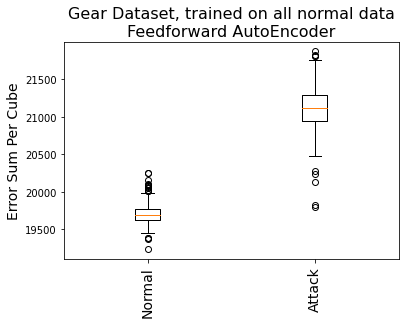

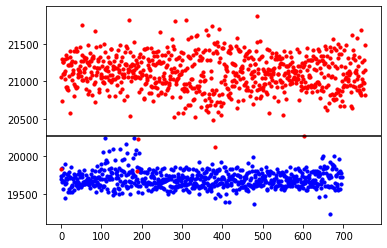

In [22]:
from matplotlib import pyplot as plt  

f = open('normal_errors.pckl', 'rb')
normal_errors = pickle.load(f)
f.close()

f = open('attack_errors.pckl', 'rb')
true_attack_errors = pickle.load(f)
f.close()

plt.figure()
plt.boxplot([normal_errors,true_attack_errors]) 
plt.xticks([1,2], ['Normal','Attack'], rotation='vertical', fontsize=14)
plt.ylabel('Error Sum Per Cube', fontsize=14)
plt.title('Gear Dataset, trained on all normal data\nFeedforward AutoEncoder', fontsize=16)

maxNormal = np.max(normal_errors) + 0.001*np.max(normal_errors)
minAttack = np.min(true_attack_errors) - 0.01*np.max(normal_errors)

plt.figure()
#plt.scatter(np.arange(len(attack_errors)),attack_errors,c='y')
plt.scatter(np.arange(len(normal_errors)), normal_errors,c='b',s=10 )
plt.scatter(np.arange(len(true_attack_errors)), true_attack_errors,c='r',s=10)
plt.axhline(y=maxNormal, color='k', linestyle='-')
#plt.axhline(y=minAttack, color='k', linestyle='--')

In [23]:
maxNormal = np.max(normal_errors) + 0.001*np.max(normal_errors)

false_normal = true_attack_errors[true_attack_errors<maxNormal]
n_false_normal = len(false_normal)
print(n_false_normal)
print(1-n_false_normal/len(true_attack_errors))
print(len(true_attack_errors))

5
0.9933862433862434
756
